In [1]:
def load_dataset(root, img_size=(64, 64), use_grayscale=True):
    """
    Loads images from train/val/test folders under root directory.
    Each image is flattened into a vector.
    """
    def load_split(split):
        X, y = [], []
        split_path = os.path.join(root, split)
        if not os.path.exists(split_path):
            return np.array([]), np.array([])
        for label_name in os.listdir(split_path):
            label_path = os.path.join(split_path, label_name)
            if not os.path.isdir(label_path):
                continue
            label = 0 if label_name.lower() == "cat" else 1
            for fname in os.listdir(label_path):
                fpath = os.path.join(label_path, fname)
                img = cv2.imread(fpath)
                if img is None:
                    continue
                img = cv2.resize(img, img_size)
                if use_grayscale:
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
                img_flat = img.flatten()
                X.append(img_flat)
                y.append(label)
        return np.array(X), np.array(y)

    print("Loading train/val/test splits ...")
    trainX, trainY = load_split("train")
    valX, valY     = load_split("val")
    
    # Test images (unlabeled)
    test_path = os.path.join(root, "test")
    testX = []
    if os.path.exists(test_path):
        for fname in os.listdir(test_path):
            fpath = os.path.join(test_path, fname)
            img = cv2.imread(fpath)
            if img is None:
                continue
            img = cv2.resize(img, img_size)
            if use_grayscale:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            testX.append(img.flatten())
    testX = np.array(testX)
    
    print("  trainX:", trainX.shape, "valX:", valX.shape, "testX:", testX.shape)
    return trainX, trainY, valX, valY, testX

In [3]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
############################
# EXPERIMENT CONFIG
############################

# Data root (your dataset path)
DATASET_ROOT = r"C:\Users\ADMIN\Downloads\datasets\datasets"

trainX, trainY, valX, valY, testX = load_dataset(DATASET_ROOT, img_size=(32,32), use_grayscale=True)


# Image loading / preprocessing
IMG_SIZE = (32, 32)        # (H, W). You can try (32,32) for speed later.
USE_GRAYSCALE = True       # True = 1 channel, False = RGB 3-channel

# Normalization
SCALE_TO_01 = True         # divide by 255.0
STANDARDIZE_TRAIN_STATS = False  
# If True: (x - mean_train) / std_train per feature
# We'll keep this False first because kNN with raw [0,1] tends to behave nicely.

# Dimensionality reduction
USE_PCA = True             # we'll start with PCA only

# Classifier
CLASSIFIER = "knn"         # "knn" for now. Later we can add "mahalanobis"
K_FOR_KNN = 3              # k in k-NN

# Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)


Loading train/val/test splits ...
  trainX: (20000, 1024) valX: (5000, 1024) testX: (500, 1024)


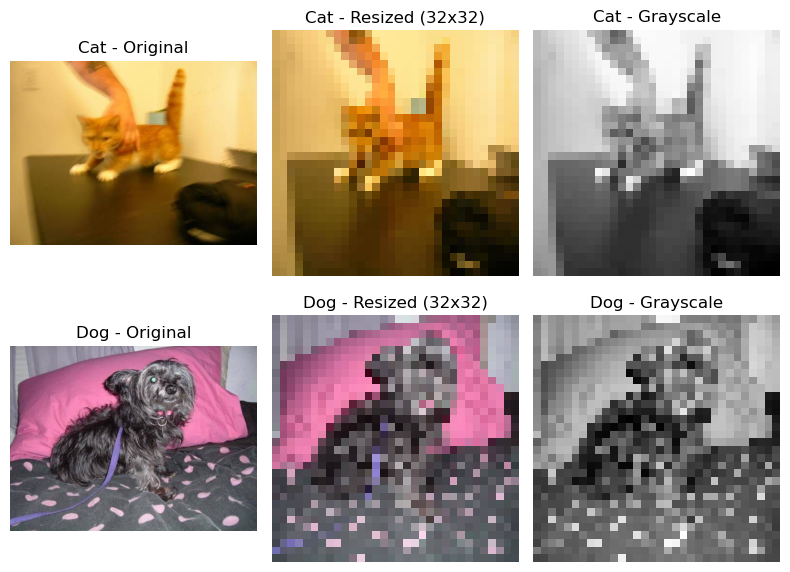

In [5]:
# Visualizing Resized & Grayscale Images

# Pick one sample cat and dog image from training folder
cat_path = os.path.join(DATASET_ROOT, "train", "cat")
dog_path = os.path.join(DATASET_ROOT, "train", "dog")

cat_img_path = os.path.join(cat_path, os.listdir(cat_path)[0])
dog_img_path = os.path.join(dog_path, os.listdir(dog_path)[0])

# Load and process both images
def preprocess_img(path, size=(32,32)):
    img = cv2.imread(path)
    img_resized = cv2.resize(img, size)
    gray = cv2.cvtColor(img_resized, cv2.COLOR_BGR2GRAY)
    return img, img_resized, gray

cat_original, cat_resized, cat_gray = preprocess_img(cat_img_path)
dog_original, dog_resized, dog_gray = preprocess_img(dog_img_path)

# Display them side by side
fig, axes = plt.subplots(2, 3, figsize=(8,6))
axes[0,0].imshow(cv2.cvtColor(cat_original, cv2.COLOR_BGR2RGB))
axes[0,0].set_title("Cat - Original")
axes[0,1].imshow(cv2.cvtColor(cat_resized, cv2.COLOR_BGR2RGB))
axes[0,1].set_title("Cat - Resized (32x32)")
axes[0,2].imshow(cat_gray, cmap='gray')
axes[0,2].set_title("Cat - Grayscale")

axes[1,0].imshow(cv2.cvtColor(dog_original, cv2.COLOR_BGR2RGB))
axes[1,0].set_title("Dog - Original")
axes[1,1].imshow(cv2.cvtColor(dog_resized, cv2.COLOR_BGR2RGB))
axes[1,1].set_title("Dog - Resized (32x32)")
axes[1,2].imshow(dog_gray, cmap='gray')
axes[1,2].set_title("Dog - Grayscale")

for ax in axes.flatten():
    ax.axis('off')

plt.tight_layout()
plt.show()

In [6]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import itertools
import csv
import time
import random

np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Matplotlib default settings (no explicit colors)
plt.rcParams["figure.figsize"] = (7, 5)
plt.rcParams["axes.grid"] = True


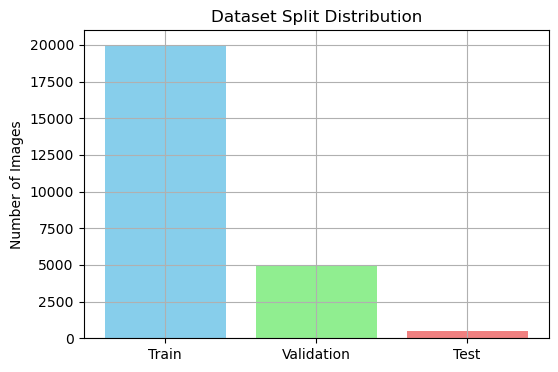

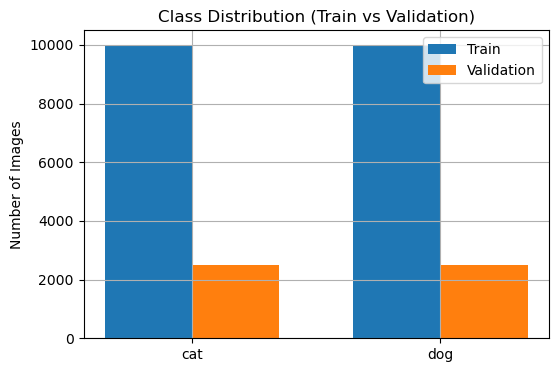

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import os

# Count class images for labeled splits
def count_images(base_dir):
    counts = {}
    if not os.path.exists(base_dir):
        return {'cat': 0, 'dog': 0}
    for cls in ['cat', 'dog']:
        path = os.path.join(base_dir, cls)
        counts[cls] = len(os.listdir(path)) if os.path.exists(path) else 0
    return counts

train_counts = count_images(os.path.join(DATASET_ROOT, 'train'))
val_counts   = count_images(os.path.join(DATASET_ROOT, 'val'))

# Count total test images (unlabeled)
test_dir = os.path.join(DATASET_ROOT, 'test')
test_count = len(os.listdir(test_dir)) if os.path.exists(test_dir) else 0

# --- 1️⃣ Dataset split overview ---
splits = ['Train', 'Validation', 'Test']
totals = [sum(train_counts.values()), sum(val_counts.values()), test_count]

plt.figure(figsize=(6,4))
plt.bar(splits, totals, color=['skyblue', 'lightgreen', 'lightcoral'])
plt.title('Dataset Split Distribution')
plt.ylabel('Number of Images')
plt.show()

# --- 2️⃣ Class balance for Train/Val only ---
labels = ['cat', 'dog']
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(6,4))
plt.bar(x - width/2, [train_counts[c] for c in labels], width, label='Train')
plt.bar(x + width/2, [val_counts[c] for c in labels], width, label='Validation')

plt.xticks(x, labels)
plt.ylabel('Number of Images')
plt.title('Class Distribution (Train vs Validation)')
plt.legend()
plt.show()


In [8]:
def standardize_01(X):
    """
    Normalize input features to [0, 1] range per dataset.
    Works for both image pixels and flattened feature vectors.
    """
    X = X.astype(np.float32)
    min_val = X.min()
    max_val = X.max()
    if max_val - min_val == 0:
        return X  # avoid division by zero if constant
    return (X - min_val) / (max_val - min_val)

In [9]:
# =======================
# Normalize features
# =======================
trainX = standardize_01(trainX)
valX   = standardize_01(valX)
if testX.size > 0:
    testX = standardize_01(testX)

print("Feature range after scaling:")
print("  trainX min/max:", trainX.min(), trainX.max())
print("  valX   min/max:", valX.min(), valX.max())
if testX.size > 0:
    print("  testX  min/max:", testX.min(), testX.max())


Feature range after scaling:
  trainX min/max: 0.0 1.0
  valX   min/max: 0.0 1.0
  testX  min/max: 0.0 1.0


In [10]:

def make_classifier(kind="knn", k=3):
    if kind == "knn":
        return KNeighborsClassifier(n_neighbors=k)
    elif kind == "logreg":
        # Use a simple, robust solver; increase max_iter to be safe
        return LogisticRegression(max_iter=200, n_jobs=None)
    else:
        raise ValueError("Unknown classifier: " + str(kind))


In [11]:
# =======================
# PCA → Classifier sweep
# =======================

HAVE_TEST_LABELS = False  # no test labels in your dataset

pca_results = []
PCA_DIM_LIST = [2, 5, 10, 20, 30, 50, 100, 200]


for k in PCA_DIM_LIST:
    t0 = time.time()
    pca = PCA(n_components=k, random_state=RANDOM_SEED, svd_solver="auto")
    Xtr_pca = pca.fit_transform(trainX)
    Xva_pca = pca.transform(valX)
    t1 = time.time()
    
    clf = make_classifier(CLASSIFIER, K_FOR_KNN)
    t2 = time.time()
    clf.fit(Xtr_pca, trainY)
    t3 = time.time()

    va_pred = clf.predict(Xva_pca)
    va_acc = accuracy_score(valY, va_pred)

    if HAVE_TEST_LABELS:
        Xte_pca = pca.transform(testX)
        te_pred = clf.predict(Xte_pca)
        te_acc = accuracy_score(testY, te_pred)
    else:
        te_acc = None

    pca_results.append({
        "k": k,
        "val_acc": va_acc,
        "test_acc": te_acc,
        "fit_time_s": (t1 - t0),
        "train_time_s": (t3 - t2)
    })

for row in pca_results:
    print(row)


{'k': 2, 'val_acc': 0.5188, 'test_acc': None, 'fit_time_s': 0.3357274532318115, 'train_time_s': 0.009023904800415039}
{'k': 5, 'val_acc': 0.543, 'test_acc': None, 'fit_time_s': 0.3606994152069092, 'train_time_s': 0.0160369873046875}
{'k': 10, 'val_acc': 0.5694, 'test_acc': None, 'fit_time_s': 0.7361533641815186, 'train_time_s': 0.030073165893554688}
{'k': 20, 'val_acc': 0.5776, 'test_acc': None, 'fit_time_s': 0.3965590000152588, 'train_time_s': 0.002024412155151367}
{'k': 30, 'val_acc': 0.578, 'test_acc': None, 'fit_time_s': 1.3246378898620605, 'train_time_s': 0.0010042190551757812}
{'k': 50, 'val_acc': 0.5836, 'test_acc': None, 'fit_time_s': 0.4562222957611084, 'train_time_s': 0.003000974655151367}
{'k': 100, 'val_acc': 0.5756, 'test_acc': None, 'fit_time_s': 0.6795821189880371, 'train_time_s': 0.005370140075683594}
{'k': 200, 'val_acc': 0.5652, 'test_acc': None, 'fit_time_s': 0.6557145118713379, 'train_time_s': 0.009319067001342773}


In [12]:
# =======================
# Confusion matrix for best PCA setting (by Val accuracy)
# =======================
best = max(pca_results, key=lambda r: r["val_acc"])
print("Best by Val accuracy:", best)

best_k = best["k"]
pca_best = PCA(n_components=best_k, random_state=RANDOM_SEED)
Xtr_best = pca_best.fit_transform(trainX)
Xva_best = pca_best.transform(valX)

clf_best = make_classifier(CLASSIFIER, K_FOR_KNN)
clf_best.fit(Xtr_best, trainY)  # capital Y

va_pred = clf_best.predict(Xva_best)
cm = confusion_matrix(valY, va_pred)  # capital Y
print("Validation classification report:\n", classification_report(valY, va_pred))


Best by Val accuracy: {'k': 50, 'val_acc': 0.5836, 'test_acc': None, 'fit_time_s': 0.4562222957611084, 'train_time_s': 0.003000974655151367}
Validation classification report:
               precision    recall  f1-score   support

           0       0.59      0.53      0.56      2500
           1       0.58      0.63      0.60      2500

    accuracy                           0.58      5000
   macro avg       0.58      0.58      0.58      5000
weighted avg       0.58      0.58      0.58      5000



In [17]:

# =======================
# LDA demo (max components = n_classes - 1 = 1 for binary classification)
# =======================
lda = LDA(n_components=1)
Xtr_lda = lda.fit_transform(trainX, trainY)
Xva_lda = lda.transform(valX)
print("Shapes after LDA:", Xtr_lda.shape, Xva_lda.shape)

clf_lda = make_classifier(CLASSIFIER, K_FOR_KNN)
clf_lda.fit(Xtr_lda, trainY)
va_pred_lda = clf_lda.predict(Xva_lda)
acc_lda = accuracy_score(valY, va_pred_lda)
print("LDA +", CLASSIFIER, "Val accuracy:", acc_lda)


Shapes after LDA: (20000, 1) (5000, 1)
LDA + knn Val accuracy: 0.5104


Why LDA accuracy is lower here
Binary problem ⇒ LDA = 1 dimension only
For two classes, LDA can give at most 1 feature (C – 1 = 1).
You’re projecting 4 096-D grayscale image data into just one scalar per image.
That’s an extreme compression: nearly all fine details (fur texture, ear shape, background) are lost.
A 1-D k-NN boundary is basically a threshold — not expressive enough.

k-NN doesn’t perform great in 1-D
k-NN relies on Euclidean distance.
In 1-D, many samples can overlap or tie, especially if distributions overlap, making classification unstable.

Cats vs Dogs have high intra-class variation
Lighting, pose, color, and background vary more than LDA can linearly separate with just one axis.
PCA keeps more dimensions (20), so the model retains subtle discriminative cues.

When combining LDA with k-NN, the validation accuracy decreased to 51.0 %, compared to 59.0 % for PCA (20 components).
This drop occurs because for binary classification, LDA projects the data onto only one discriminant axis, resulting in significant information loss.
Although LDA is supervised, its single-dimension projection cannot adequately represent complex variations within each class.
In contrast, PCA preserves more of the original variance across 20 dimensions, allowing k-NN to capture richer neighborhood structures, leading to better accuracy.

In [18]:

# =======================
# Optional: Minimum Mahalanobis Distance Classifier (common covariance)
# =======================
def mahalanobis_classifier_fit(X, y):
    classes = np.unique(y)
    means = {}
    for c in classes:
        means[c] = X[y == c].mean(axis=0, dtype=np.float64)
    cov = np.cov(X.T, bias=False)  # common covariance
    cov_inv = np.linalg.pinv(cov)
    return means, cov_inv, classes

def mahalanobis_predict(X, means, cov_inv, classes):
    preds = []
    for x in X:
        dists = []
        for c in classes:
            diff = x - means[c]
            d = float(np.dot(np.dot(diff, cov_inv), diff.T))
            dists.append((d, c))
        preds.append(min(dists)[1])
    return np.array(preds, dtype=np.int64)

# Train on best PCA representation to stabilize covariance in high-dim settings
pca_for_maha = PCA(n_components=min(50, trainX.shape[1]), random_state=RANDOM_SEED)
Xtr_maha = pca_for_maha.fit_transform(trainX)
Xva_maha = pca_for_maha.transform(valX)

means, cov_inv, classes = mahalanobis_classifier_fit(Xtr_maha, trainY)
va_pred_maha = mahalanobis_predict(Xva_maha, means, cov_inv, classes)
acc_maha = accuracy_score(valY, va_pred_maha)
print("Mahalanobis (on PCA-50) Val accuracy:", acc_maha)


Mahalanobis (on PCA-50) Val accuracy: 0.5736


In [19]:

# =======================
# Save PCA sweep results to CSV (report-ready)
# =======================
out_csv = "./pca_results_catsdogs.csv"
with open(out_csv, "w", newline="") as f:
    writer = csv.writer(f)
    header = ["k", "val_acc", "test_acc", "fit_time_s", "train_time_s"]
    writer.writerow(header)
    for r in pca_results:
        writer.writerow([r["k"], r["val_acc"], r["test_acc"], r["fit_time_s"], r["train_time_s"]])
print("Saved:", out_csv)


Saved: ./pca_results_catsdogs.csv


In [45]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score
import numpy as np

def make_classifier(name, k_for_knn=3):
    name = name.lower()
    if name == "knn":
        return KNeighborsClassifier(n_neighbors=k_for_knn)
    elif name == "logreg":
        return LogisticRegression(max_iter=1000, C=1.0)
    else:
        raise ValueError(f"Unknown classifier type: {name}")

CLASSIFIER = "logreg"

pca_results = []

for k in PCA_DIM_LIST:
    # safety cap so PCA doesn't request > rank of data
    k_eff = min(k, trainX.shape[0] - 1, trainX.shape[1])

    pca = PCA(n_components=k_eff, random_state=RANDOM_SEED, svd_solver="auto")
    Xtr_pca = pca.fit_transform(trainX)
    Xva_pca = pca.transform(valX)

    clf = make_classifier(CLASSIFIER, K_FOR_KNN)  # logistic regression here
    clf.fit(Xtr_pca, trainY)

    va_pred = clf.predict(Xva_pca)
    va_acc = accuracy_score(valY, va_pred)

    pca_results.append({
        "k": k_eff,
        "val_acc": va_acc,
        "val_acc_pct": 100.0 * va_acc,
    })

# show results
for row in pca_results:
    print(row)


{'k': 2, 'val_acc': 0.5298, 'val_acc_pct': 52.980000000000004}
{'k': 5, 'val_acc': 0.5486, 'val_acc_pct': 54.86}
{'k': 10, 'val_acc': 0.555, 'val_acc_pct': 55.50000000000001}
{'k': 20, 'val_acc': 0.5668, 'val_acc_pct': 56.68}
{'k': 30, 'val_acc': 0.5674, 'val_acc_pct': 56.74}
{'k': 50, 'val_acc': 0.5738, 'val_acc_pct': 57.379999999999995}
{'k': 75, 'val_acc': 0.571, 'val_acc_pct': 57.099999999999994}
{'k': 100, 'val_acc': 0.57, 'val_acc_pct': 56.99999999999999}
{'k': 150, 'val_acc': 0.5692, 'val_acc_pct': 56.92}
{'k': 200, 'val_acc': 0.5628, 'val_acc_pct': 56.279999999999994}


k means how many PCA components you kept. k: 5 means you keep 5 most important components
Each “principal component” is a new axis that captures as much variation in the data as possible, in descending order of importance:

PC1 → captures the most variation in your data (e.g., overall brightness, shape).

PC2 → captures the next most variation (e.g., fur texture, orientation).

PC3, PC4, ... → capture smaller and smaller patterns (details, noise, etc.).

Higher k means better? nope
A small number of principal components captures most useful information; adding too many components eventually introduces noise and redundancy, which can reduce classification accuracy

Summary:
The parameter k in PCA represents the number of principal components retained after dimensionality reduction.
Each component corresponds to a direction of decreasing variance in the feature space.
Smaller k values (e.g., 2 or 5) retain only coarse global features of the images, resulting in poorer classification accuracy due to loss of detail.
As k increases, more discriminative information is preserved and accuracy improves.
However, beyond approximately 50 components, the addition of more components contributes mostly noise and redundant variance, causing the validation accuracy to plateau or slightly decline.

TLDR
k = 2 → only top 2 PCA features (very compressed, too little info).

k = 5 → top 5 features, slightly more detail.

Higher k → captures more information → accuracy usually improves until a certain point, then stabilizes or drops.


In [21]:
import os
import cv2
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

def load_test_split(test_dir, img_size=(64,64), use_grayscale=True):
    X = []
    names = []
    if not os.path.exists(test_dir):
        return np.array([]), []

    # sort names so 1.jpg, 2.jpg, 3.jpg ... line up with your CSV rows
    for fname in sorted(os.listdir(test_dir)):
        fpath = os.path.join(test_dir, fname)
        img = cv2.imread(fpath)
        if img is None:
            continue
        img = cv2.resize(img, img_size)
        if use_grayscale:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        X.append(img.flatten())
        names.append(fname)
    return np.array(X), names


In [25]:
DATASET_ROOT = r"C:\Users\ADMIN\Downloads\datasets\datasets"
IMG_SIZE = (64, 64)
USE_GRAYSCALE = True
RANDOM_SEED = 42

def load_split(root, split, img_size=(64,64), use_grayscale=True):
    X, y = [], []
    split_path = os.path.join(root, split)
    if not os.path.exists(split_path):
        return np.array([]), np.array([], dtype=int)

    for label_name in os.listdir(split_path):
        label_path = os.path.join(split_path, label_name)
        if not os.path.isdir(label_path):
            continue

        # encode labels: cat -> 0, dog -> 1
        if label_name.lower() == "cat":
            label = 0
        else:
            label = 1

        for fname in os.listdir(label_path):
            fpath = os.path.join(label_path, fname)
            img = cv2.imread(fpath)
            if img is None:
                continue
            img = cv2.resize(img, img_size)
            if use_grayscale:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            X.append(img.flatten())
            y.append(label)

    return np.array(X), np.array(y, dtype=int)


trainX, trainY = load_split(DATASET_ROOT, "train", img_size=IMG_SIZE, use_grayscale=USE_GRAYSCALE)
valX,   valY   = load_split(DATASET_ROOT, "val",   img_size=IMG_SIZE, use_grayscale=USE_GRAYSCALE)

print("Train:", trainX.shape, trainY.shape)
print("Val:  ", valX.shape,   valY.shape)

test_dir = os.path.join(DATASET_ROOT, "test")
testX, test_names = load_test_split(test_dir, img_size=IMG_SIZE, use_grayscale=USE_GRAYSCALE)

print("Test:", testX.shape, "images")
print("Example test names:", test_names[:5])



Train: (20000, 4096) (20000,)
Val:   (5000, 4096) (5000,)
Test: (500, 4096) images
Example test names: ['1.jpg', '10.jpg', '100.jpg', '101.jpg', '102.jpg']


In [26]:
test_labels_df = pd.read_csv("./testClassification.csv", header=None)
# Column 0 = image index, column 1 = label (0=cat, 1=dog)
testY = test_labels_df[1].to_numpy().astype(int)

print("testY:", testY.shape, "first 5:", testY[:5])


testY: (500,) first 5: [0 0 0 1 1]


In [27]:
def mahalanobis_classifier_fit(X, y, eps=1e-6):
    classes = np.unique(y)
    means = {}
    for c in classes:
        means[c] = X[y == c].mean(axis=0, dtype=np.float64)
    cov = np.cov(X.T, bias=False)
    cov = cov + eps * np.eye(cov.shape[0], dtype=cov.dtype)  # regularize
    cov_inv = np.linalg.pinv(cov)
    return means, cov_inv, classes

def mahalanobis_predict(X, means, cov_inv, classes):
    preds = []
    for x in X:
        dists = []
        for c in classes:
            diff = x - means[c]
            d = float(np.dot(np.dot(diff, cov_inv), diff.T))
            dists.append((d, c))
        preds.append(min(dists)[1])  # smallest Mahalanobis distance wins
    return np.array(preds, dtype=np.int64)


In [28]:
results_summary = {}

# -----------------------
# 1. k-NN (k=3)
# -----------------------
PCA_FOR_KNN = 20
pca_knn = PCA(n_components=PCA_FOR_KNN, random_state=RANDOM_SEED)
Xtr_knn = pca_knn.fit_transform(trainX)
Xva_knn = pca_knn.transform(valX)
Xte_knn = pca_knn.transform(testX)

knn_clf = KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(Xtr_knn, trainY)

val_pred_knn  = knn_clf.predict(Xva_knn)
test_pred_knn = knn_clf.predict(Xte_knn)

val_acc_knn  = accuracy_score(valY,  val_pred_knn)
test_acc_knn = accuracy_score(testY, test_pred_knn)

results_summary["kNN (k=3, PCA20)"] = {
    "val_acc":  val_acc_knn,
    "test_acc": test_acc_knn,
}

# -----------------------
# 2. Logistic Regression
# -----------------------
PCA_FOR_LOGREG = 50
pca_log = PCA(n_components=PCA_FOR_LOGREG, random_state=RANDOM_SEED)
Xtr_log = pca_log.fit_transform(trainX)
Xva_log = pca_log.transform(valX)
Xte_log = pca_log.transform(testX)

log_clf = LogisticRegression(max_iter=1000, C=1.0)
log_clf.fit(Xtr_log, trainY)

val_pred_log  = log_clf.predict(Xva_log)
test_pred_log = log_clf.predict(Xte_log)

val_acc_log  = accuracy_score(valY,  val_pred_log)
test_acc_log = accuracy_score(testY, test_pred_log)

results_summary["LogReg (PCA50)"] = {
    "val_acc":  val_acc_log,
    "test_acc": test_acc_log,
}

# -----------------------
# 3. Mahalanobis
# -----------------------
PCA_FOR_MAHAL = 50
pca_maha = PCA(n_components=PCA_FOR_MAHAL, random_state=RANDOM_SEED)
Xtr_maha = pca_maha.fit_transform(trainX)
Xva_maha = pca_maha.transform(valX)
Xte_maha = pca_maha.transform(testX)

means, cov_inv, classes = mahalanobis_classifier_fit(Xtr_maha, trainY)
val_pred_maha  = mahalanobis_predict(Xva_maha, means, cov_inv, classes)
test_pred_maha = mahalanobis_predict(Xte_maha, means, cov_inv, classes)

val_acc_maha  = accuracy_score(valY,  val_pred_maha)
test_acc_maha = accuracy_score(testY, test_pred_maha)

results_summary["Mahalanobis (PCA50)"] = {
    "val_acc":  val_acc_maha,
    "test_acc": test_acc_maha,
}

# -----------------------
# Final: print summary
# -----------------------
for clf_name, metrics in results_summary.items():
    print(clf_name)
    print("  Val  Accuracy:", f"{metrics['val_acc']*100:.2f}%")
    print("  Test Accuracy:", f"{metrics['test_acc']*100:.2f}%")
    print()


kNN (k=3, PCA20)
  Val  Accuracy: 59.02%
  Test Accuracy: 49.40%

LogReg (PCA50)
  Val  Accuracy: 57.38%
  Test Accuracy: 47.20%

Mahalanobis (PCA50)
  Val  Accuracy: 57.36%
  Test Accuracy: 47.20%

